In [2]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.8.0 Tensorflow Current Version: 2.16.1


In [2]:
!pip uninstall tf-keras

Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/tf_keras-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tf_keras/*
Proceed (Y/n)? Y
  Successfully uninstalled tf_keras-2.18.0


In [1]:
!pip install tensorflow==2.16.1

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

In [6]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()




def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):

    if batch_size is None:
        batch_size = len(X_train)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset


In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = data.data
y = data.target
# Kontrol: Boyutlar ve sınıf dağılımı
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sınıf dağılımı:", np.bincount(y))  # [kötü huylu, iyi huylu]

X shape: (569, 30)
y shape: (569,)
Sınıf dağılımı: [212 357]


In [8]:
from sklearn.model_selection import train_test_split

# %80 eğitim, %20 validasyon (doğrulama) olacak şekilde ayırıyoruz
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=46)

# Kontrol amaçlı boyutlara bakalım
print("Eğitim verisi:", X_train.shape, y_train.shape)
print("Doğrulama verisi:", X_val.shape, y_val.shape)


Eğitim verisi: (455, 30) (455,)
Doğrulama verisi: (114, 30) (114,)


In [9]:
# StandardScaler nesnesi oluştur
scaler = StandardScaler()

# Sadece eğitim verisine fit (ölçek hesapla), sonra transform et (uygula)
X_train_scaled = scaler.fit_transform(X_train)

# Validation verisine sadece transform (aynı ölçekleri kullan)
X_val_scaled = scaler.transform(X_val)

# Kontrol
print("Ölçeklenmiş X_train ortalaması:", X_train_scaled.mean(axis=0).round(2))
print("Ölçeklenmiş X_train std:", X_train_scaled.std(axis=0).round(2))

Ölçeklenmiş X_train ortalaması: [-0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.
  0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0.  0.]
Ölçeklenmiş X_train std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [10]:
# Eğer önceki prepare_datasets fonksiyonunu tanımladıysan:
train_dataset, val_dataset = prepare_datasets(X_train_scaled, X_val_scaled, y_train, y_val, batch_size=32)

# Kontrol edelim
for batch_x, batch_y in train_dataset.take(1):
    print("Bir batch'in X boyutu:", batch_x.shape)
    print("Bir batch'in y boyutu:", batch_y.shape)


Bir batch'in X boyutu: (32, 30)
Bir batch'in y boyutu: (32,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Modelin tanımı
model = Sequential([
    Input(shape=(30,)),  # Giriş: 30 özellik (X_train_scaled.shape[1])

    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),  # Gizli katman + L2
    BatchNormalization(),  # Aktivasyon çıktılarını normalize et
    Dropout(0.5),          # Rastgele %30 nöron kapat → overfitting azalt

    Dense(1, activation='sigmoid')  # Çıkış katmanı: Binary sınıflandırma
])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,801 (7.04 KB)

 Trainable params: 1,701 (6.64 KB)

 Non-trainable params: 100 (400.00 B)

In [13]:
from tensorflow.keras.optimizers import SGD

# Modeli derleyelim (compile)
model.compile(
    optimizer=SGD(),  # İstenen optimizer
    loss='binary_crossentropy',  # Binary classification için en uygun loss
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Başarı ölçütleri
)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback tanımı
early_stop = EarlyStopping(
    monitor='val_loss',     # Ne zaman durmalı? → Validasyon loss yükselmeye başladığında
    patience=5,             # Kaç epoch beklesin? → 5 epoch boyunca iyileşme yoksa durdur
    restore_best_weights=True  # En iyi modeli geri yükle
)


In [18]:
history = model.fit(
            train_dataset,
            epochs=1000,
            validation_data=val_dataset,
            verbose=1,
            callbacks=[early_stop]
)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7534 - auc: 0.8196 - loss: 0.5702 - val_accuracy: 0.8772 - val_auc: 0.9602 - val_loss: 0.4250
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8185 - auc: 0.9129 - loss: 0.4356 - val_accuracy: 0.9035 - val_auc: 0.9708 - val_loss: 0.3658
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8299 - auc: 0.9201 - loss: 0.3925 - val_accuracy: 0.9123 - val_auc: 0.9769 - val_loss: 0.3236
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8725 - auc: 0.9333 - loss: 0.3613 - val_accuracy: 0.9211 - val_auc: 0.9818 - val_loss: 0.2870
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8502 - auc: 0.9211 - loss: 0.3844 - val_accuracy: 0.9298 - val_auc: 0.9834 - val_loss: 0.2661
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8958 - auc: 0.9488 - loss: 0.3045 - val_accuracy: 0.9386 - val_auc: 0.9852 - val_loss: 0.2442
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━

In [20]:
best_epoch = early_stop.stopped_epoch - early_stop.patience
print("En iyi epoch:", best_epoch)


En iyi epoch: 76


In [23]:
val_loss = history.history['val_loss'][best_epoch]
val_accuracy = history.history['val_accuracy'][best_epoch]
val_auc = history.history['auc'][best_epoch]

print(f"Epoch {best_epoch}: val_loss = {val_loss:.4f}, val_accuracy = {val_accuracy:.4f}, val_auc = {val_auc:.4f}")


Epoch 76: val_loss = 0.1097, val_accuracy = 0.9825, val_auc = 0.9878


In [22]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(train_metric)
    plt.legend()
    plt.show()


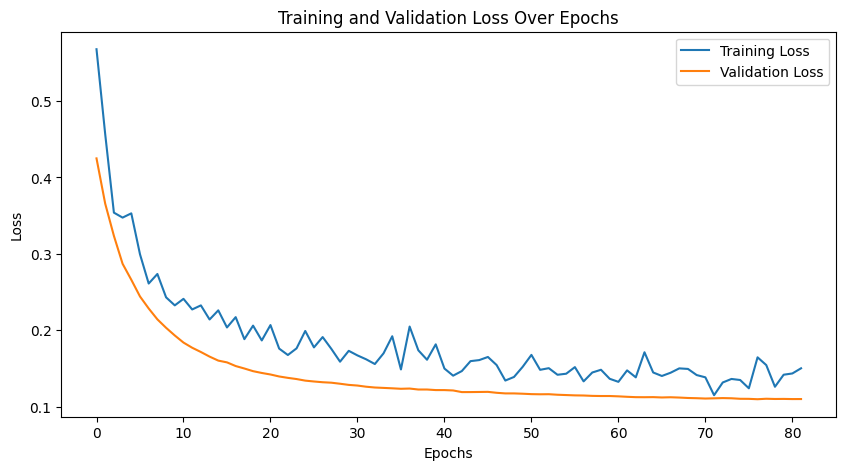

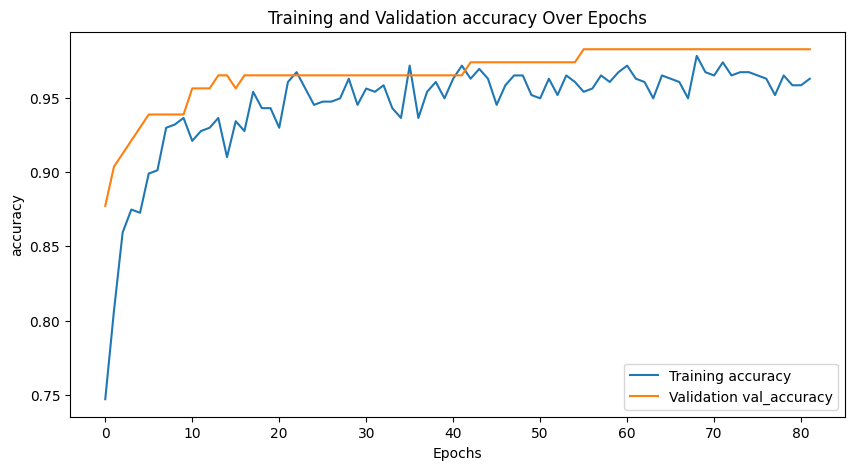

In [24]:
plot_training_history(history)


🧠 SONUÇ: Aşırı Öğrenme (Overfitting) YOK

📌 Neden?
val_loss grafiğinde bir yükseliş yok.
val_accuracy eğrisi "plateau" olmuş ama düşmemiş.
EarlyStopping zaten doğru zamanda durdurmuş.
Regularizasyon (L2), Dropout ve BatchNormalization etkili olmuş ✅